In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import math
from tensorflow.contrib import rnn

%matplotlib notebook

In [43]:
# Parameters
learning_rate = 0.001
training_iters = 2500
batch_size = 1
display_step = 10

# Network Parameters
n_input = 5 # MNIST data input (img shape: 28*28)
n_steps = 100 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = n_steps # MNIST total classes (0-9 digits)

# Data Parameters
dataParam = dict(
    freq = 2,
    section = 8,
    baseline = 2,
    rows = 300,
    stop = 20,
    n_steps = n_steps,
    n_input = n_input
)

In [65]:
class DataGenerator:
#     def __init__(self, **kwargs):
    def __init__(self, kwargs):
        self.freq = kwargs['freq']
        self.section = kwargs['section']
        self.baseline = kwargs['baseline']
        self.rows = kwargs['rows']
        self.stop = kwargs['stop']
        self.n_steps = kwargs['n_steps']
        self.n_input = kwargs['n_input']
        self.it = 0;
        self.epoch = 0;
        
    def _generate_data(self, freq, section, baseline, rows=10, stop=100, steps=250):
        data = np.tile(np.linspace(0, stop, steps), rows).reshape(rows, steps)
        f, s, b = np.random.random((3, rows)) * np.array([freq, section, baseline])[:,np.newaxis]
        return np.sin(data * f[:,np.newaxis] + s[:,np.newaxis]) + b[:,np.newaxis]

    def _make_time_steps(self, arr, n_steps, n_input):
        B = np.zeros(shape=(arr.shape[0], n_steps, n_input))
        for i in range(n_steps):B[:,i,:]=arr[:,i:n_input+i]
        return B, arr[:,n_input:]
    
    def generate_train_data(self, r=0):
        r = self.rows if r == 0 else r
        X_orig = self._generate_data(self.freq, self.section, self.baseline, 
                                     rows=r, stop=self.stop, steps=self.n_steps + self.n_input)
        X, Y = self._make_time_steps(X_orig, self.n_steps, self.n_input)
        self.X_orig, self.X_train, self.Y_train = X_orig, X, Y

    def generate(self, r=0):
        r = self.rows if r == 0 else r
        X_orig = self._generate_data(self.freq, self.section, self.baseline, 
                                     rows=r, stop=self.stop, steps=self.n_steps + self.n_input)
        X, Y = self._make_time_steps(X_orig, self.n_steps, self.n_input)
        return X_orig, X, Y
    
    def next(self, num=5):
        if self.X_orig.shape[0] % num != 0:
            raise Exception('Invalid num')
            
        i = self.it
        self.it += num
        if self.it >= self.X_orig.shape[0]:
            self.it = 0
            self.epoch += 1
        return self.X_orig[i:i+num], self.X_train[i:i+num], self.Y_train[i:i+num]

dg = DataGenerator(dataParam)
dg.generate_train_data()
X_orig, X_train, Y_train = dg.next(10)

print(X_orig.shape)
print(X_train.shape)
print(Y_train.shape)
print(dg.X_orig.shape)

(10, 105)
(10, 100, 5)
(10, 100)
(3000, 105)


In [66]:
tf.reset_default_graph()
g = tf.Graph()
sess = tf.InteractiveSession(graph=g)

x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(x, weights, biases):
    x = tf.unstack(x, n_steps, 1)
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

cost = tf.nn.l2_loss(pred - y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

sess.run(init)
step = 1
while step * batch_size < training_iters:
    _, batch_x, batch_y = dg.next(30)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    if step % display_step == 0:
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(loss)) 
#               + ", Training Accuracy= " + "{:.5f}".format(acc))
    step += 1
    
print("Optimization Finished!")

test_len = 128
_, test_data, test_label = dg.generate(test_len)
print("Testing Accuracy:", \
    sess.run(cost, feed_dict={x: test_data, y: test_label}))

Iter 10, Minibatch Loss= 3031.142578
Iter 20, Minibatch Loss= 1723.331299
Iter 30, Minibatch Loss= 1125.259766
Iter 40, Minibatch Loss= 1105.823730
Iter 50, Minibatch Loss= 911.420898
Iter 60, Minibatch Loss= 826.356750
Iter 70, Minibatch Loss= 891.516357
Iter 80, Minibatch Loss= 830.508179
Iter 90, Minibatch Loss= 734.916443
Iter 100, Minibatch Loss= 452.450745
Iter 110, Minibatch Loss= 704.071106
Iter 120, Minibatch Loss= 1052.075684
Iter 130, Minibatch Loss= 741.541138
Iter 140, Minibatch Loss= 788.577942
Iter 150, Minibatch Loss= 753.054626
Iter 160, Minibatch Loss= 686.102539
Iter 170, Minibatch Loss= 810.663330
Iter 180, Minibatch Loss= 710.618408
Iter 190, Minibatch Loss= 659.241028
Iter 200, Minibatch Loss= 609.064331
Iter 210, Minibatch Loss= 664.359009
Iter 220, Minibatch Loss= 706.478027
Iter 230, Minibatch Loss= 613.624756
Iter 240, Minibatch Loss= 618.133362
Iter 250, Minibatch Loss= 641.172119
Iter 260, Minibatch Loss= 601.639587
Iter 270, Minibatch Loss= 668.208984
Iter 

Iter 2220, Minibatch Loss= 10.967596
Iter 2230, Minibatch Loss= 10.301395
Iter 2240, Minibatch Loss= 11.435745
Iter 2250, Minibatch Loss= 13.825415
Iter 2260, Minibatch Loss= 14.351826
Iter 2270, Minibatch Loss= 12.533392
Iter 2280, Minibatch Loss= 12.575808
Iter 2290, Minibatch Loss= 14.312359
Iter 2300, Minibatch Loss= 9.564106
Iter 2310, Minibatch Loss= 9.421523
Iter 2320, Minibatch Loss= 11.083968
Iter 2330, Minibatch Loss= 9.313339
Iter 2340, Minibatch Loss= 12.324253
Iter 2350, Minibatch Loss= 12.714315
Iter 2360, Minibatch Loss= 12.731734
Iter 2370, Minibatch Loss= 12.019356
Iter 2380, Minibatch Loss= 17.309486
Iter 2390, Minibatch Loss= 16.328434
Iter 2400, Minibatch Loss= 12.161870
Iter 2410, Minibatch Loss= 13.545538
Iter 2420, Minibatch Loss= 10.434200
Iter 2430, Minibatch Loss= 10.928923
Iter 2440, Minibatch Loss= 11.736055
Iter 2450, Minibatch Loss= 12.157933
Iter 2460, Minibatch Loss= 12.461779
Iter 2470, Minibatch Loss= 9.247110
Iter 2480, Minibatch Loss= 13.476520
Iter 

In [91]:
def plot(num=9, col=3, train=True, fig_count=0):
    fig = plt.figure(fig_count)
    if train:
        print('Train')
        X_orig, X, Y = dg.next(num)
    else:
        print('Test')
        X_orig, X, Y = dg.generate(num)
    prediction = sess.run(pred, feed_dict={x: X, y: Y})
    c = sess.run(cost, feed_dict={x: X, y: Y})
    print("Cost %f" % c)
    t = np.linspace(0, dataParam['stop'], n_steps+n_input)
    row = math.ceil(num / col) 
    for i in range(0, num):
        plt.subplot(row,col,i+1)
        plt.plot(t, X_orig[i])
        plt.plot(t[-n_steps:], prediction[i])

<IPython.core.display.Javascript object>


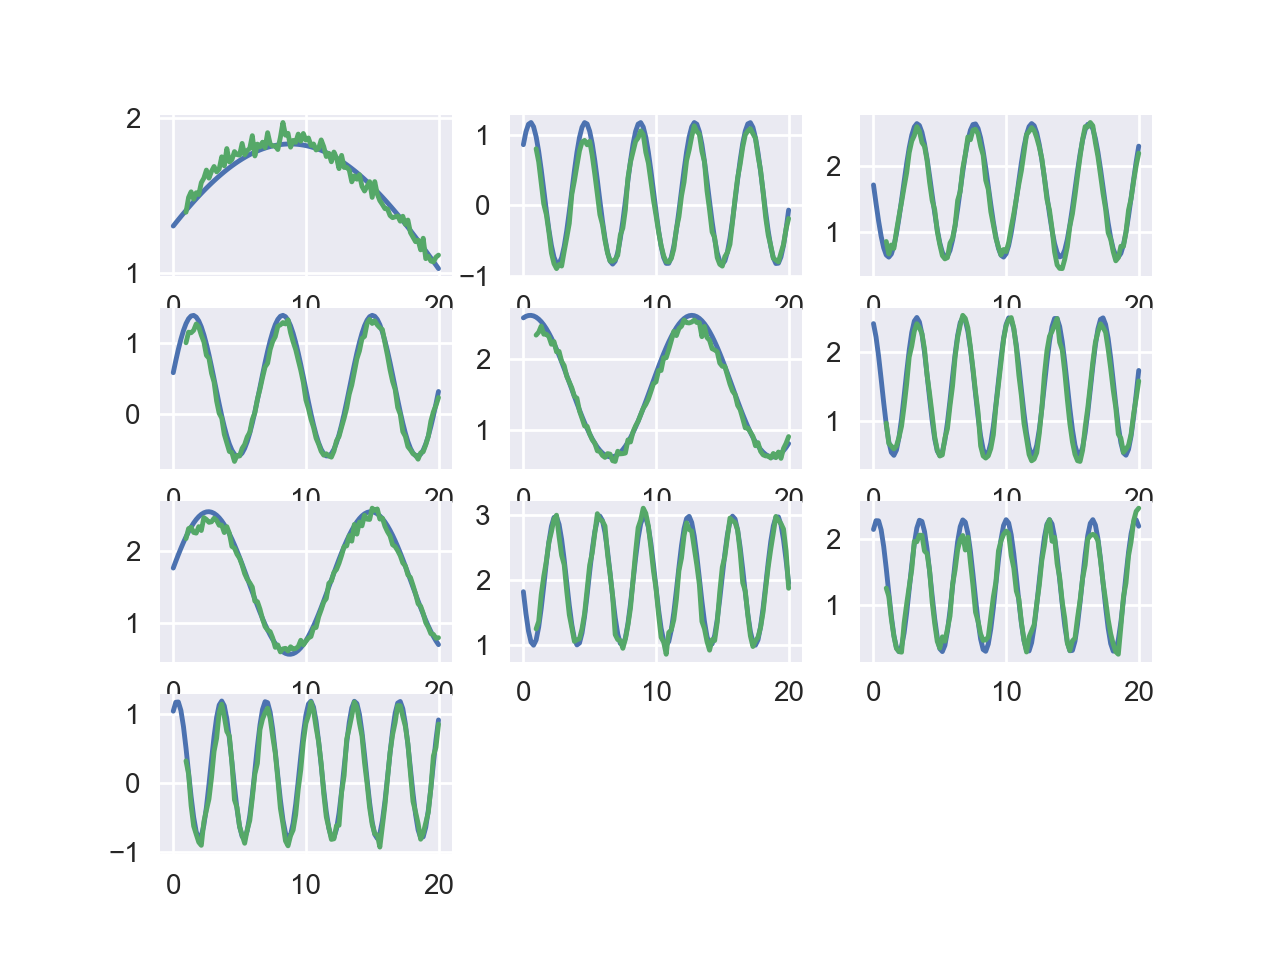

Train
Cost 4.538936


<IPython.core.display.Javascript object>


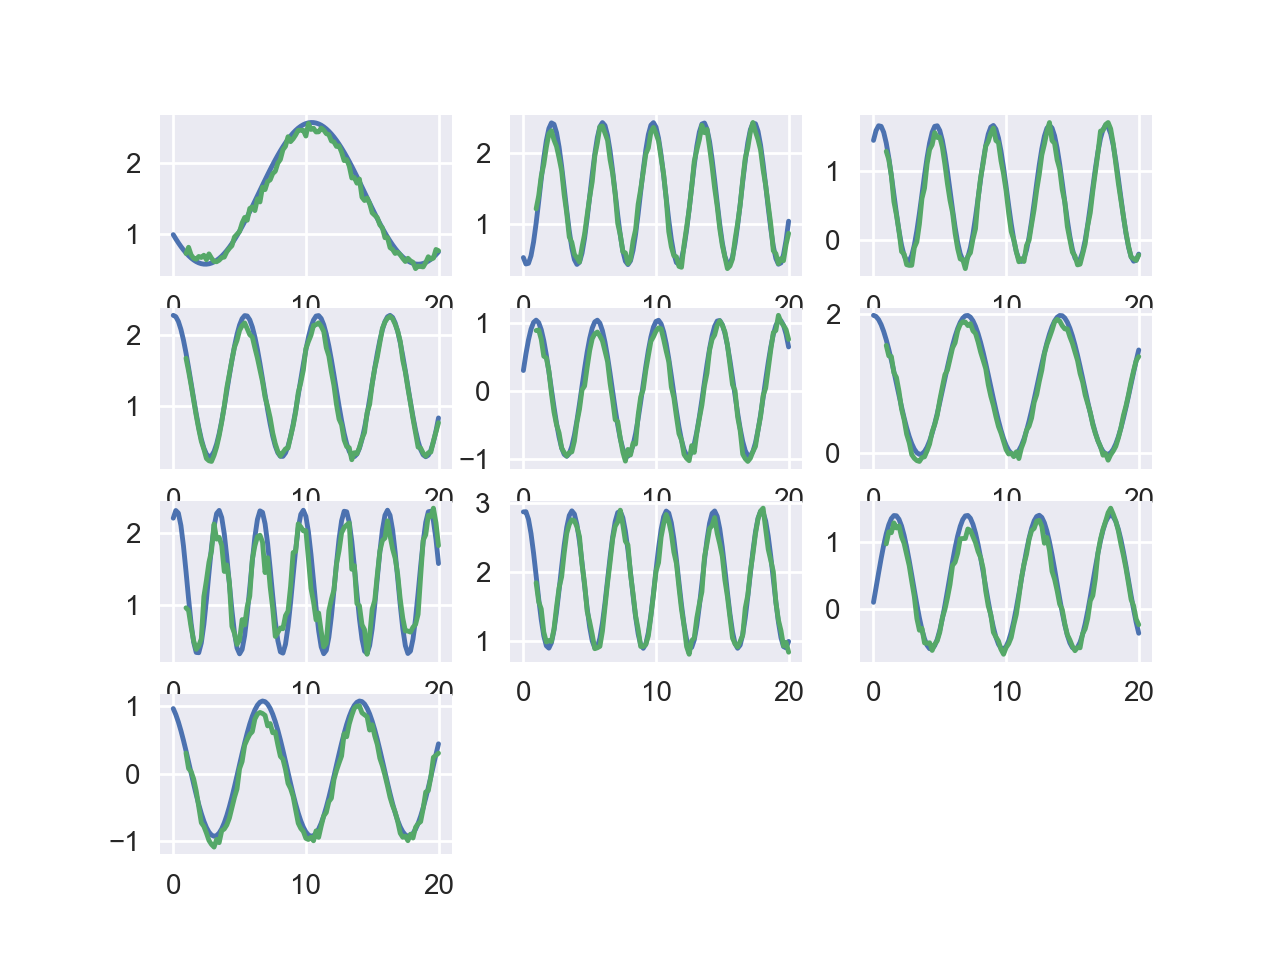

Test
Cost 6.629943


In [94]:
fc = 1
plot(num=10, train=True, fig_count=fc)

fc += 1
plot(num=10, train=False, fig_count=fc)